In [196]:
excludes = ['power.Core']

def parse_data(data_folder, workloads):
    data = {}

    for wl in workloads:
        baseline_res = get_results_map(data_folder, wl)
        data[wl] = baseline_res

    return data


def get_results_map(fodler_path, workload):
    filename = fodler_path + "/" + workload + ".txt" 
    d = {}
    with open(filename, "r") as file:
        lines = file.readlines()

        for line in lines:
            line = line.strip()
            splits = line.split(" ")

            if (not splits[0].startswith("power.")):    
                d[splits[0]] = float(splits[2])


    return d

In [216]:
import pandas as pd
import matplotlib.pyplot as plt


workloads = [
    "bc",
    "bfs",
    "cc",
    "dlrm",
    "gc",
    "gen",
    "pr",
    "rnd",
    "sssp",
    "tc",
    "xs"
]


paths = ['./temp/victima_no_pref', './bypassing_l2/complete_bypass/radix', './bypassing_l2/complete_bypass/victima']
headings = ['Victima no pref', 'Radix complete bypass', 'Victima complete bypass']

data_dfs = []


for path in paths:
    res = parse_data(path, workloads)
    data_df = pd.DataFrame(res)
    data_dfs.append(data_df)


In [198]:
def convert_to_cycles(femtosecs):
    return femtosecs / 384615

In [199]:
# Assuming df1 and df2 are your two DataFrames
def compare(dfs, labels):
    merged_df = pd.concat(dfs, axis=1)
    merged_df.columns = labels
    return merged_df

In [211]:
# generic get attribute function
def get_attr(df, attr, label):
    dt = pd.DataFrame(index=[label], columns=workloads)

    for wl in workloads:
        dt.at[label, wl] = df[wl][attr]

    return dt.T


def compare_attr(dfs, labels, attr):
    mer = [get_attr(df, attr, label) for df, label in zip(dfs, labels)]
    return compare(mer, labels)


In [ ]:
print(compare_attr(data_dfs, headings, 'L1-D.total-latency'))

## Get STLB Miss Penalties

In [201]:
def get_stlb_miss_penalties_df(df):
    label = 'STLB Miss Penalty'
    # Initialize an empty DataFrame with 'STLB Miss Penalty' as the index
    stlb_miss_penalty = pd.DataFrame(index=[label], columns=workloads)

    for wl in workloads:
        # Compute the STLB miss penalty
        penalty = convert_to_cycles(df[wl]['mmu.total_ptw_latency'] / df[wl]['PTW_0.page_walks'])
        stlb_miss_penalty.at[label, wl] = round(penalty, 2)

    return stlb_miss_penalty.T


In [202]:
print(get_stlb_miss_penalties_df(data_dfs[0]))

     STLB Miss Penalty
bc              133.74
bfs             119.34
cc              120.28
dlrm            118.89
gc              122.12
gen             122.27
pr              119.21
rnd              55.01
sssp            135.58
tc              120.66
xs               48.89


## Get Cache MPKI

In [203]:
MISSES_TLB_BLOCKS = 'load-misses-tlb_entry'
MISSES_DATA_BLOCKS = 'load-misses-non_page_table'
MISSES_PTE_BLOCKS = 'load-misses-page_table'


DATA_BLOCK = 'Data'
PTE_BLOCK = 'PTE'
TLB_BLOCK = 'TLB'


block_type = {
    MISSES_TLB_BLOCKS: TLB_BLOCK,
    MISSES_DATA_BLOCKS: DATA_BLOCK,
    MISSES_PTE_BLOCKS: PTE_BLOCK,
}

# Now return a df as done in the previous function
def get_cache_mpki(df, cache_name, misses_name):
    label = f'{cache_name} {block_type[misses_name]} MPKI'
    mpki = pd.DataFrame(index=[label], columns=workloads)
    attr = cache_name + '.' + misses_name

    for wl in workloads:
        mpki.at[label, wl] = round(df[wl][attr] / df[wl]['core.instructions'] * 1000, 2)

    return mpki.T



In [204]:
# print(get_cache_mpki(data_dfs[0], 'L2', MISSES_DATA_BLOCKS))
# print(get_cache_mpki(data_dfs[0], 'L2', MISSES_TLB_BLOCKS))
# print(get_cache_mpki(data_dfs[0], 'L2', MISSES_PTE_BLOCKS))

## NUCA Cache analysis

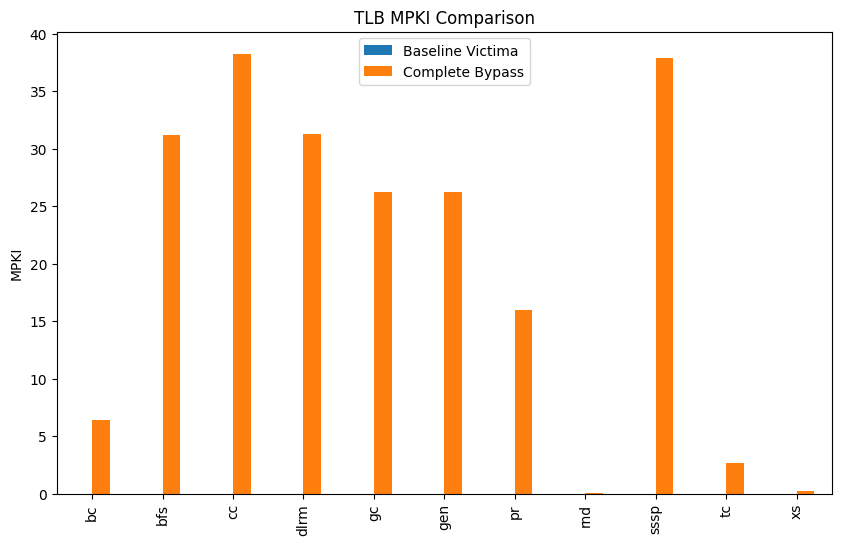

In [205]:
d1 = get_cache_mpki(data_dfs[0], 'L2', MISSES_TLB_BLOCKS)
d2 = get_cache_mpki(data_dfs[1], 'L2', MISSES_TLB_BLOCKS)
lab = ['Baseline Victima', 'Complete Bypass']
cmp = compare([d1, d2], lab)


# plot the comparison
cmp.plot(kind='bar', figsize=(10, 6))
plt.ylabel('MPKI')
plt.title('TLB MPKI Comparison')
plt.show()

In [206]:
# compare stlb miss penalties
d1 = get_stlb_miss_penalties_df(data_dfs[0])
d2 = get_stlb_miss_penalties_df(data_dfs[1])
lab = ['Baseline Victima', 'Complete Bypass']
cmp = compare([d1, d2], lab)
print(cmp)

     Baseline Victima Complete Bypass
bc             133.74          214.04
bfs            119.34          200.46
cc             120.28          200.96
dlrm           118.89          200.45
gc             122.12          230.56
gen            122.27           230.6
pr             119.21          195.61
rnd             55.01          205.01
sssp           135.58          219.69
tc             120.66          193.54
xs              48.89          193.62


## The REUSE values!

In [207]:
import pandas as pd

DATA_REUSE = 'data'
PTE_REUSE = 'metadata'
TLB_REUSE = 'tlb'

def get_reuse_attrs(cache_name, type):
    return [f'{cache_name}.{type}-reuse-{i}' for i in range(5)]

def get_cache_reuse(df, cache_name, type):
    attrs = get_reuse_attrs(cache_name, type)

    # Initialize DataFrame properly with attributes as rows and workloads as columns
    reuse = pd.DataFrame(index=attrs, columns=workloads)

    for wl in workloads:
        for attr in attrs:
            reuse.at[attr, wl] = df[wl][attr]  # Assign values correctly

    reuse = reuse.T

    # now calculate the percentage of each reuse level
    for wl in workloads:
        total = reuse.loc[wl].sum()
        for attr in attrs:
            reuse.at[wl, attr] = round(reuse.at[wl, attr] / total * 100, 2)

    # add a row for mean values
    reuse.loc['mean'] = reuse.mean()

    return reuse  # Transpose to maintain workload as rows


d1 = get_cache_reuse(data_dfs[0], 'nuca-cache', DATA_REUSE)
print(d1)


     nuca-cache.data-reuse-0 nuca-cache.data-reuse-1 nuca-cache.data-reuse-2  \
bc                     41.11                   58.88                    0.01   
bfs                     89.2                   10.79                    0.01   
cc                     92.68                    7.31                    0.01   
dlrm                    89.2                   10.79                    0.01   
gc                     95.94                    4.06                     0.0   
gen                    95.94                    4.06                     0.0   
pr                     71.18                   28.82                     0.0   
rnd                     0.14                   99.86                     0.0   
sssp                   95.99                    4.01                     0.0   
tc                     86.46                   13.54                     0.0   
xs                     100.0                     0.0                     0.0   
mean               77.985455            

## Get the IPC

In [232]:
def get_ipc(df):
    label = 'IPC'
    ipc = pd.DataFrame(index=[label], columns=workloads)

    for wl in workloads:
        ipc.at[label, wl] = df[wl]['ipc']

    return ipc.T

def get_normalized_speedup(df_base, df_cmp):
    label = 'Normalized Speedup'
    speedup = pd.DataFrame(index=[label], columns=workloads)

    for wl in workloads:
        speedup.at[label, wl] = df_cmp[wl]['ipc'] / df_base[wl]['ipc']

    return speedup.T

# print(get_ipc(data_dfs[0]))

sp = get_normalized_speedup(data_dfs[0], data_dfs[2])
print(sp)


#plot the speedups
# sp.plot(kind='bar', figsize=(10, 6))
# plt.ylabel('Normalized Speedup')
# plt.title('Normalized Speedup Baseline Victima vs Complete Bypass')
# plt.show()

     Normalized Speedup
bc             1.014996
bfs            1.027308
cc             1.029066
dlrm           1.027034
gc             1.036661
gen            1.039436
pr             1.003613
rnd            0.751558
sssp           1.039867
tc             1.043183
xs             1.051757


## DRAM reads and Writes

In [209]:
# Analyze the dram.reads and dram.writes
def get_dram_traffic(df):
    label = 'DRAM Traffic'
    dram_traffic = pd.DataFrame(index=[label], columns=workloads)

    for wl in workloads:
        dram_traffic.at[label, wl] = df[wl]['dram.reads'] + df[wl]['dram.writes']

    return dram_traffic.T


def get_dram_reads(df):
    label = 'DRAM Reads'
    dram_reads = pd.DataFrame(index=[label], columns=workloads)

    for wl in workloads:
        dram_reads.at[label, wl] = df[wl]['dram.reads']

    return dram_reads.T


def get_dram_writes(df):
    label = 'DRAM Writes'
    dram_writes = pd.DataFrame(index=[label], columns=workloads)

    for wl in workloads:
        dram_writes.at[label, wl] = df[wl]['dram.writes']

    return dram_writes.T



drt = compare([get_dram_traffic(data_dfs[0]), get_dram_traffic(data_dfs[1])], ['Baseline Victima', 'Complete Bypass'])
drr = compare([get_dram_reads(data_dfs[0]), get_dram_reads(data_dfs[1])], ['Baseline Victima', 'Complete Bypass'])
drw = compare([get_dram_writes(data_dfs[0]), get_dram_writes(data_dfs[1])], ['Baseline Victima', 'Complete Bypass'])

## add a column that tells by how many times is the difference
drt['Difference'] = drt['Complete Bypass'] / drt['Baseline Victima']
drr['Difference'] = drr['Complete Bypass'] / drr['Baseline Victima']
drw['Difference'] = drw['Complete Bypass'] / drw['Baseline Victima']


print(drt)
print(drr)
print(drw)

     Baseline Victima Complete Bypass Difference
bc         30213204.0      33348315.0   1.103766
bfs        98818553.0     113534398.0   1.148918
cc        114021291.0     132256090.0   1.159925
dlrm       98813844.0     113593471.0    1.14957
gc         78109710.0      92385738.0   1.182769
gen        78099491.0      91848240.0   1.176041
pr         98521388.0     105294853.0   1.068751
rnd       113915480.0     113911244.0   0.999963
sssp       99634517.0     120636735.0   1.210793
tc         13170853.0      14160450.0   1.075135
xs         16932741.0      17039608.0   1.006311
     Baseline Victima Complete Bypass Difference
bc         17239819.0      20724889.0   1.202152
bfs        89960395.0     104802124.0   1.164981
cc        107093186.0     125408003.0   1.171018
dlrm       89952837.0     104862326.0   1.165748
gc         75105528.0      89388215.0   1.190168
gen        75095779.0      89395481.0    1.19042
pr         73931147.0      80904705.0   1.094325
rnd        38173556.

## Get Miss Latency

In [227]:
# Now return a df as done in the previous function
def get_cache_miss_penalty(df, cache_name):
    label = f'{cache_name} Miss Penalty'
    mpki = pd.DataFrame(index=[label], columns=workloads)
    load_misses_attr = cache_name + '.tload-misses'
    store_misses_attr = cache_name + '.tstore-misses'
    tot_latency_attr = cache_name + '.total-latency'


    for wl in workloads:
        mpki.at[label, wl] = round(df[wl][tot_latency_attr] / (df[wl][load_misses_attr] + df[wl][store_misses_attr]), 2)
        mpki.at[label, wl] = convert_to_cycles(mpki.at[label, wl])

    return mpki.T


d = [get_cache_miss_penalty(di, 'L1-D') for di, li in zip(data_dfs, headings)]
cmp = compare(d, headings)

print(cmp)

     Victima no pref Radix complete bypass Victima complete bypass
bc        110.807487             80.667678               89.090869
bfs       116.788169             97.950079              112.851085
cc        118.328326              99.93114              114.615796
dlrm      116.778262             98.473071              112.809296
gc        121.085988            107.951347              124.711208
gen       121.076234              107.7252              116.014483
pr        106.887598            100.942672              108.740261
rnd         69.13078             64.494628               79.507115
sssp      134.490119            114.286891              123.897334
tc           119.357            104.797474              115.124837
xs        109.306375             97.698048              105.093261
